# Local Endpoint QPS/Latency

The goal of this experiment is to understand the limit of what a single endpoint can handle within local system. We test this by launching a bunch of workers on the system with the endpoint that make `get`/`set` requests to the endpoint. Note: that this does not test any of the endpoint-to-endpoint p2p capabilities

## Instructions

### Setup

1. Clone and install https://github.com/proxystore/proxystore-benchmarks
   ```bash
   $ git clone git@github.com:proxystore/proxystore-benchmarks.git
   $ cd proxystore-benchmarks
   $ virtualenv venv
   $ . venv/bin/activate
   $ pip install -e .
   ```
2. Configure a ProxyStore endpoint
   ```bash
   $ proxystore-endpoint configure psbench
   $ proxystore-endpoint start psbench &> /dev/null &
   ```
   Note: endpoint logs will still be written to ~/.proxystore
   
### Run

```bash
$ python -m psbench.benchmarks.endpoint_qps \
    {ENDPOINT UUID} \
    --route SET \
    --queries 1000 \
    --workers 4 \
    --payload-size 1000
```

### Notes:
- The provided results were collected on a Perlmutter CPU node (2 AMD EPYC 7763 [64 cores/socket, 2 threads/core], 512 GB RAM)
  ```bash
  $ salloc --qos interactive --constraint cpu --account={PROJECT-ID} -t 2:00:00
  ```

In [1]:
%matplotlib inline

import math

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import pandas
import numpy
import seaborn

# to change default colormap
plt.rcParams["image.cmap"] = "tab10"
# to change default color cycle
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.tab10.colors)

In [2]:
ROUTE_COLUMN = 'route'
PAYLOAD_COLUMN = 'payload_size_bytes'
WORKERS_COLUMN = 'workers'
LATENCY_AVG_COLUMN = 'avg_latency_ms'
LATENCY_STDEV_COLUMN = 'stdev_latency_ms'

def load(filepath: str) -> pandas.DataFrame:
    return pandas.read_csv(filepath)

In [3]:
DATA = load('data/endpoint-latency-local/perlmutter-cpu-node-endpoint-qps.csv')
DATA.head()

,route,payload_size_bytes,total_queries,sleep_seconds,workers,min_worker_elapsed_time_ms,max_worker_elapsed_time_ms,avg_worker_elapsed_time_ms,stdev_worker_elapsed_time_ms,min_latency_ms,max_latency_ms,avg_latency_ms,stdev_latency_ms,qps
0,GET,1000,100,0,1,301.346453,301.346453,301.346453,0.000000,2.791755,3.866633,3.013465,0.142322,331.843959
1,GET,1000,200,0,2,418.193720,418.209295,418.201508,0.011013,3.692951,20.796488,4.182015,1.655427,478.229447
2,GET,1000,400,0,4,559.697290,567.951267,565.674617,4.003029,3.165911,8.829466,5.656746,0.838944,704.285778
3,GET,1000,800,0,8,966.857971,991.401070,981.333686,8.706175,4.790171,24.774034,9.813337,1.683490,806.938810
4,GET,1000,1600,0,16,1551.307216,1836.222087,1790.567142,78.462131,3.536962,38.338635,17.905671,3.207241,871.354294


In [4]:
def rows_matching_column_value(data: pandas.DataFrame, column: str, value) -> pandas.DataFrame:
    return data.loc[data[column] == value]

def extract_series(data: pandas.DataFrame, route: str, payload_size: int) -> dict[str, list[str]]:
    data = rows_matching_column_value(data, ROUTE_COLUMN, route)
    data = rows_matching_column_value(data, PAYLOAD_COLUMN, payload_size)
    return {
        'workers': list(data[WORKERS_COLUMN]),
        'avg_latency': list(data[LATENCY_AVG_COLUMN]),
        'stdev_latency': list(data[LATENCY_STDEV_COLUMN]),
    }
    
def extract(data: pandas.DataFrame, route: str) -> dict[str, dict[str, list[str]]]:
    payloads = data[PAYLOAD_COLUMN].unique()
    return {payload: extract_series(data, route, payload) for payload in payloads}

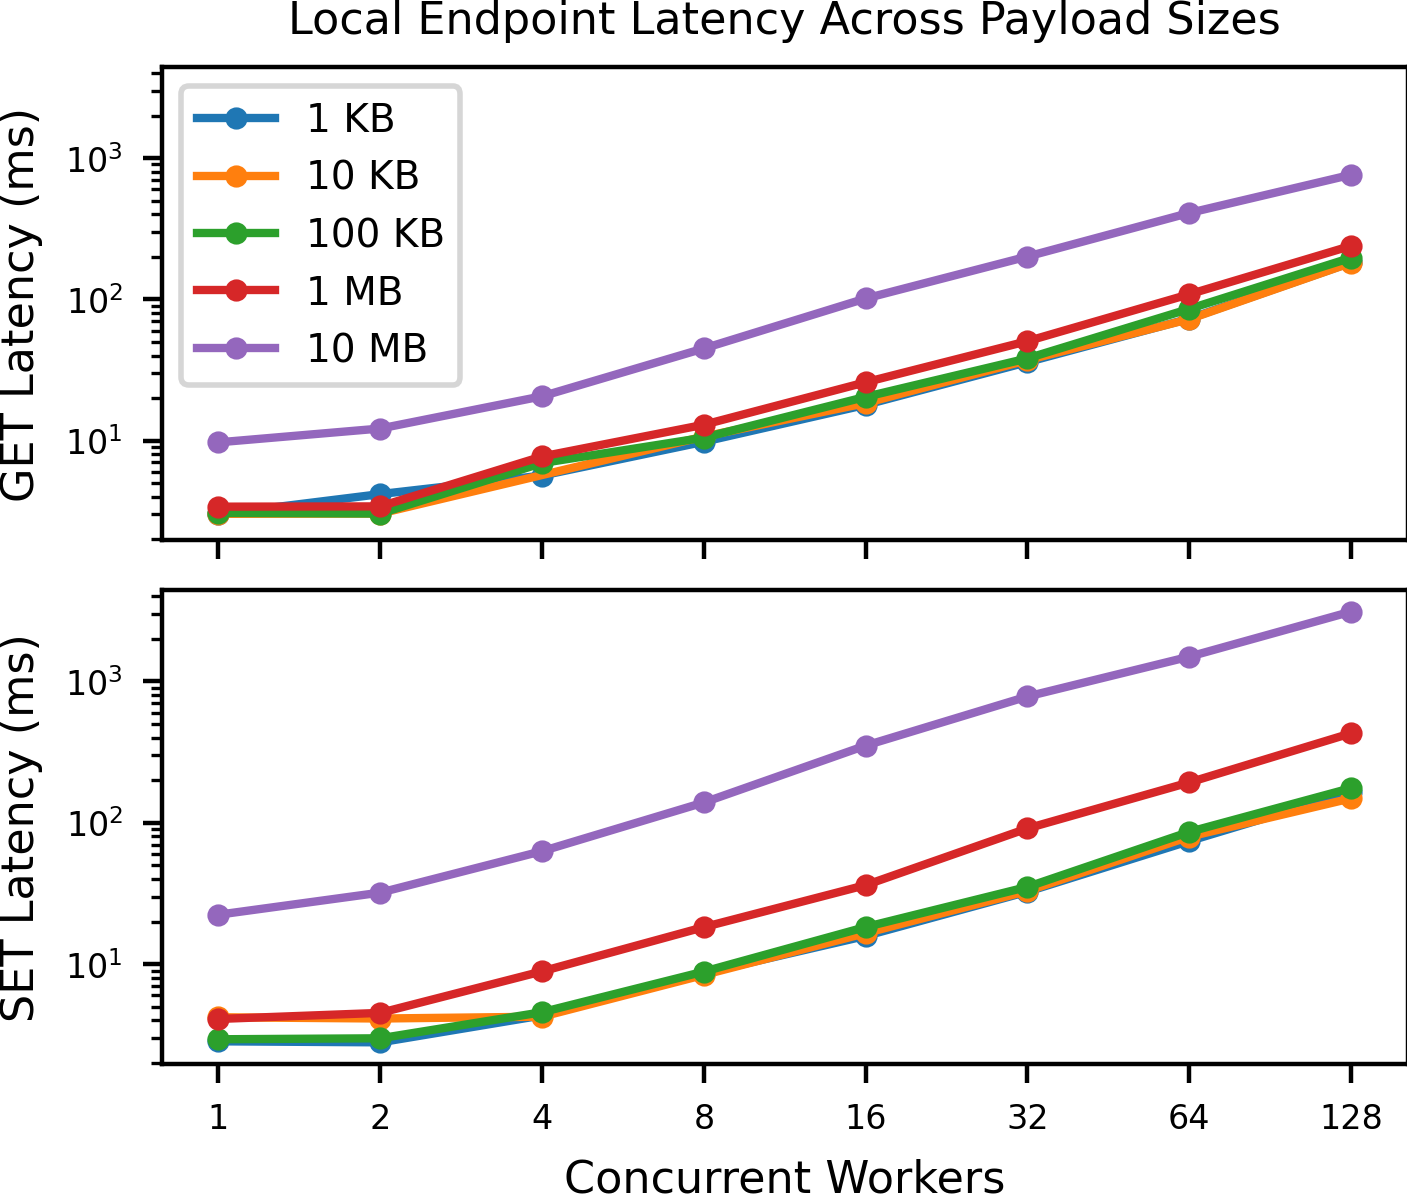

In [6]:
GET_DATA = extract(DATA, 'GET')
SET_DATA = extract(DATA, 'SET')

payload_labels = ['1 KB', '10 KB', '100 KB', '1 MB', '10 MB']

fig, axs = plt.subplots(2, 1, sharex=True, sharey=True)

for data, ax in zip((GET_DATA, SET_DATA), axs):
    ax.set_yscale('log', base=10)
    ax.set_xscale('log', base=2)

    for payload, series in data.items():
        ax.plot(series['workers'], series['avg_latency'], marker='.', label=payload)

axs[0].set_title('Local Endpoint Latency Across Payload Sizes')
axs[-1].set_xlabel('Concurrent Workers')
axs[0].set_ylabel('GET Latency (ms)')
axs[1].set_ylabel('SET Latency (ms)')

# Use integer x labels instead of powers of 2
axs[-1].get_xaxis().set_major_formatter(mticker.FormatStrFormatter('%.0f'))

axs[0].legend(payload_labels, loc='upper left')

fig.tight_layout()

fig.set_size_inches(3.5, 3)
plt.savefig('figures/endpoint-latency-local.png', )